A partir del archivo Euro_2012_stats_TEAM, se pide:

1. Obtener la matriz de correlación. ¿Qué columnas están mejor correlacionadas?

2. ¿Existe algún tipo de relación entre la precisión de disparo a puerta (Shooting Accuracy) con respecto a los goles? Muestra en una gráfica (pintando la línea en la distribución de ambas variables) y usando Regresión Lineal, Regresión no Lineal con polinomio y SVR la relación entre ambos. Por cada porcentaje de acierto de cara a puerta, ¿cuánto aumenta o disminuye el número de goles? 

3. Si tratamos la columna Goals como una columna categórica y usando logistic regression, SVM y Random forest, ¿cuántos goles marcaría un equipo que tiene...? (por cada algoritmo):

    - % de goles por disparo: 40%
    - Total shots (inc. Blocked): 102
    - Corners Taken: 5
    - Passes: 82
    - Dribbles: 23

In [82]:
import pandas as pd
import seaborn as sns
import numpy as np

from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR, SVC

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [83]:
df = pd.read_csv("https://raw.githubusercontent.com/Gabvaztor/data_science_apr_2021/main/week10_ML_competition_pca_kmeans/day1_gridsearch_pipelines/data/Euro_2012_stats_TEAM.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Team                        16 non-null     object 
 1   Goals                       16 non-null     int64  
 2   Shots on target             16 non-null     int64  
 3   Shots off target            16 non-null     int64  
 4   Shooting Accuracy           16 non-null     object 
 5   % Goals-to-shots            16 non-null     object 
 6   Total shots (inc. Blocked)  16 non-null     int64  
 7   Hit Woodwork                16 non-null     int64  
 8   Penalty goals               16 non-null     int64  
 9   Penalties not scored        16 non-null     int64  
 10  Headed goals                16 non-null     int64  
 11  Passes                      16 non-null     int64  
 12  Passes completed            16 non-null     int64  
 13  Passing Accuracy            16 non-nu

In [84]:
df[df.dtypes[df.dtypes == "object"].index].head()

,Team,Shooting Accuracy,% Goals-to-shots,Passing Accuracy,Saves-to-shots ratio
0,Croatia,51.9%,16.0%,76.9%,81.3%
1,Czech Republic,41.9%,12.9%,78.1%,60.1%
2,Denmark,50.0%,20.0%,83.3%,66.7%
3,England,50.0%,17.2%,80.6%,88.1%
4,France,37.9%,6.5%,87.2%,54.6%


In [85]:
# para poder seguir trabajando con este dataset, lo primero es convertir estas columnas a numéricas

df.Team.unique()

array(['Croatia', 'Czech Republic', 'Denmark', 'England', 'France',
       'Germany', 'Greece', 'Italy', 'Netherlands', 'Poland', 'Portugal',
       'Republic of Ireland', 'Russia', 'Spain', 'Sweden', 'Ukraine'],
      dtype=object)

In [86]:
le = LabelEncoder()
df["Team"] = le.fit_transform(df["Team"])

In [87]:
col_obj_col = df[df.dtypes[df.dtypes == "object"].index].columns.tolist()
print(f"Los valores de las columnas {col_obj_col[0]}, {col_obj_col[1]}, {col_obj_col[2]} y {col_obj_col[3]} siguen\nsiendo de tipo object ya que sus valores contienen el elemento '%'")

Los valores de las columnas Shooting Accuracy, % Goals-to-shots, Passing Accuracy y Saves-to-shots ratio siguen
siendo de tipo object ya que sus valores contienen el elemento '%'


In [88]:
for col in col_obj_col:    
    df[col] = df[col].apply(lambda x: float(x[:-1]))

In [89]:
df.head()

,Team,Goals,Shots on target,Shots off target,Shooting Accuracy,% Goals-to-shots,Total shots (inc. Blocked),Hit Woodwork,Penalty goals,Penalties not scored,...,Saves made,Saves-to-shots ratio,Fouls Won,Fouls Conceded,Offsides,Yellow Cards,Red Cards,Subs on,Subs off,Players Used
0,0,4,13,12,51.9,16.0,32,0,0,0,...,13,81.3,41,62,2,9,0,9,9,16
1,1,4,13,18,41.9,12.9,39,0,0,0,...,9,60.1,53,73,8,7,0,11,11,19
2,2,4,10,10,50.0,20.0,27,1,0,0,...,10,66.7,25,38,8,4,0,7,7,15
3,3,5,11,18,50.0,17.2,40,0,0,0,...,22,88.1,43,45,6,5,0,11,11,16
4,4,3,22,24,37.9,6.5,65,1,0,0,...,6,54.6,36,51,5,6,0,11,11,19


**1. Obtener la matriz de correlación. ¿Qué columnas están mejor correlacionadas?**

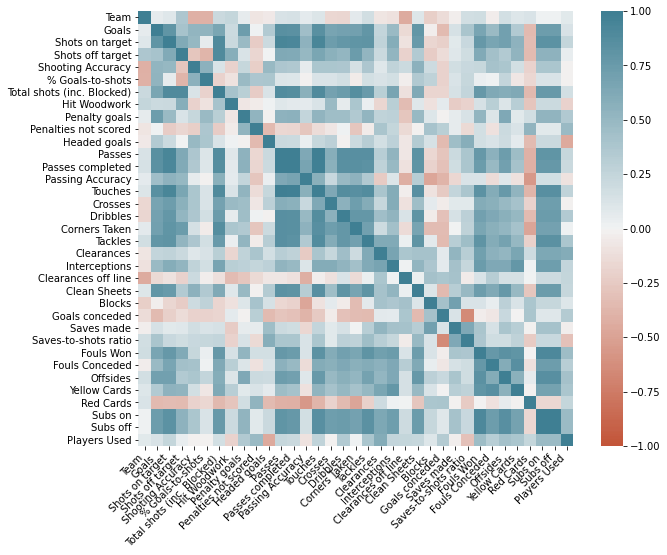

In [90]:
corr_matrix = df.corr()

plt.subplots(figsize=(10, 8))

#sns.heatmap(corr_matrix, cmap = "PiYG", square=True)

ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [91]:
correlation_df = df.corr()[(df.corr() > 0.95) & (df.corr() < 1)]
more_correlated = [column for column in correlation_df.notna().columns if any(correlation_df.notna()[column] == True)]
print("Las siguientes columnas presentan una correlación mayor del 95% con cualquier otra columna del dataframe:\n",more_correlated)

Las siguientes columnas presentan una correlación mayor del 95% con cualquier otra columna del dataframe:
 ['Passes', 'Passes completed', 'Touches']


**2. ¿Existe algún tipo de relación entre la precisión de disparo a puerta (Shooting Accuracy) con respecto a los goles? Muestra en una gráfica (pintando la línea en la distribución de ambas variables) y usando Regresión Lineal, Regresión no Lineal con polinomio y SVR la relación entre ambos. Por cada porcentaje de acierto de cara a puerta, ¿cuánto aumenta o disminuye el número de goles?** 

In [92]:
df['Goals'].corr(df['Shooting Accuracy'])

0.5212095324544346

In [93]:
print(f"La correlación entre ambas columnas es del {round((df['Shooting Accuracy'].corr(df['Goals']))*100, 2)}%")

La correlación entre ambas columnas es del 52.12%


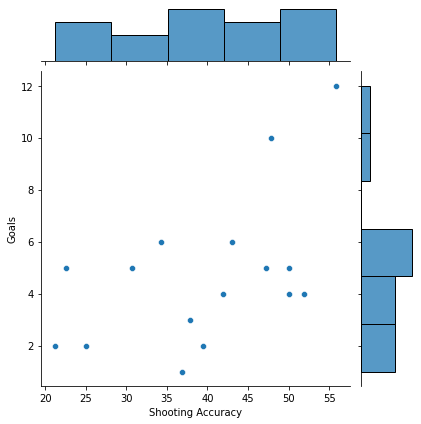

In [94]:
sns.jointplot(x = "Shooting Accuracy", y= "Goals", data = df)

In [108]:
dictionary_model_reg = {"poly_model": Pipeline([
            ("polynomial_features", PolynomialFeatures(3)),
            ("linear_regression", LinearRegression())]),
                    "linear_model": LinearRegression(),
                    "support_model": SVR(),
                    "random_forest": RandomForestRegressor()
                   }


X = np.array(df["Shooting Accuracy"]).reshape(-1,1)
y = df.Goals

In [107]:
dictionary_model_reg['poly_model']

Pipeline(steps=[('polynomial_features', PolynomialFeatures(degree=3)),
                ('linear_regression', LinearRegression())])

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state = 42)
print(X_train.shape, y_train.shape)


for k,v in dictionary_model_reg.items():
    print(k)
    print(v)
    print('---')


(12, 1) (12,)
poly_model
Pipeline(steps=[('polynomial_features', PolynomialFeatures(degree=3)),
                ('linear_regression', LinearRegression())])
---
linear_model
LinearRegression()
---
support_model
SVR()
---
random_forest
RandomForestRegressor()
---


In [97]:
def train_model_reg(dict_model, X, y):
    dict_scores = {"model":[], "score":[], "score_test":[]}
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state = 42)
    print(X_train.shape, y_train.shape)
    
    for k,v in dict_model.items():         
        v.fit(X_train, y_train)
        y_pred = v.predict(X_train)
        y_test_pred = v.predict(X_test)

        score = r2_score(y_train, y_pred)
        score_test = r2_score(y_test, y_test_pred)
   
        lista_val = [k, score, score_test]
        for i,e in enumerate(["model", "score","score_test"]):
            dict_scores[e].append(lista_val[i])

        X_train_to_show, y_train_to_show = zip(*sorted(zip(X_train, y_train)))
        plt.scatter(X_train_to_show, y_train_to_show, color='lightblue')
        
        X_t_to_show, y_t_to_show = zip(*sorted(zip(X_test, y_test)))
        plt.scatter(X_t_to_show, y_t_to_show, color='red')
                                       
        X_train_to_show, y_pred = zip(*sorted(zip(X_train, y_pred)))
        plt.plot(X_train_to_show, y_pred, color='blue')
        plt.title(f"{k}")
        plt.show()
        
    return pd.DataFrame(dict_scores)

(12, 1) (12,)


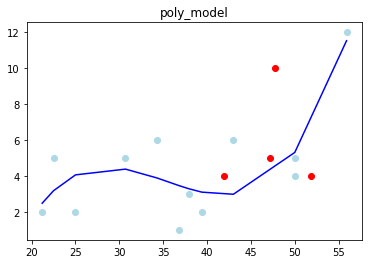

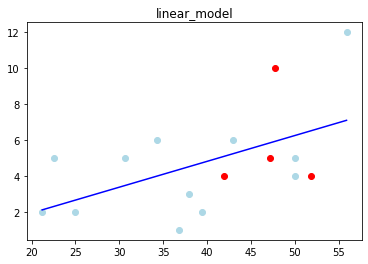

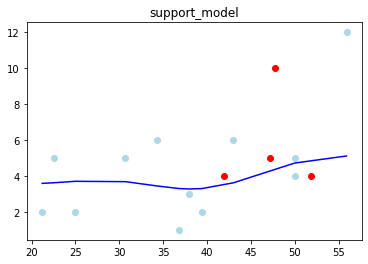

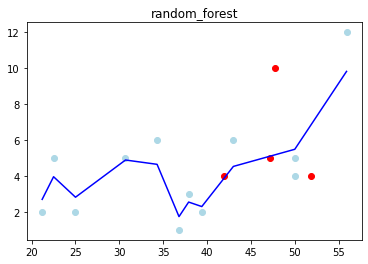

,model,score,score_test
0,poly_model,0.671936,-0.820066
1,linear_model,0.301706,-0.001941
2,support_model,0.196019,-0.335333
3,random_forest,0.849704,-0.092454


In [98]:
train_model_reg(dict_model=dictionary_model_reg, X=X, y=y)

**3. Si tratamos la columna Goals como una columna categórica y usando logistic regression, SVM y Random forest, ¿cuántos goles marcaría un equipo que tiene...? (por cada algoritmo):**

    - % de goles por disparo: 40%
    - Total shots (inc. Blocked): 102
    - Corners Taken: 5
    - Passes: 82
    - Dribbles: 23

In [99]:
cat_type = CategoricalDtype(categories=[1,2,3,4,5,6,10,12],
                            ordered=True)

df.Goals = df.Goals.astype(cat_type)

In [117]:
df.Goals.dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 10, 12], ordered=True)

In [101]:
dictionary_model_class = {"randomforest_model": RandomForestClassifier(),
                    "log_model": LogisticRegression(),
                    "support_model": SVC()
                   }

X = df[['% Goals-to-shots','Total shots (inc. Blocked)','Corners Taken','Passes','Dribbles']]
y = df.Goals

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [103]:
# pruebo con los datos de test, pero son tan pocos que el accuracy es pequeñísimo
for k, v in dictionary_model_class.items():
    v.fit(X_train, y_train)
    y_pred = v.predict(X_test)
    print("score train:", v.score(X_train, y_train), "\n")
    print("score test:", v.score(X_test, y_test), "\n")
    print("accuracy:", accuracy_score(y_test, y_pred), "\n")

score train: 1.0 

score test: 0.0 

accuracy: 0.0 

score train: 0.75 

score test: 0.25 

accuracy: 0.25 

score train: 0.4166666666666667 

score test: 0.0 

accuracy: 0.0 



In [104]:
def train_model_class(dict_model, X, y, X_pred):
    dict_pred = {"model":[], "prediction":[]}
    
    for k,v in dict_model.items():         
        v.fit(X, y)
        y_pred = v.predict(X_pred.reshape(1,-1))
   
        lista_val = [k, y_pred[0]]
        for i,e in enumerate(["model", "prediction"]):
            dict_pred[e].append(lista_val[i])
            
    return pd.DataFrame(dict_pred)

In [105]:
X_pred = np.array([40.0,102.0,5.0,82.0,23.0])

In [106]:
train_model_class(dict_model=dictionary_model_class, X=X, y=y, X_pred=X_pred)

,model,prediction
0,randomforest_model,5
1,log_model,6
2,support_model,5
